# Comparing Calibration Data Across All Models / Question Sets

In [1]:
%%capture
%pip install -r requirements.txt

In [2]:
# Initialize
import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from pathlib import Path
import json


## Combine All Results Into Composite CSV

First we will read from the Parsed Results folder and make a dictionary that abstracts the structure of the directory

In [3]:
# Read the folder and create a dictionary to model the structure of the files

def folder_tree_dict(root, *, include_files=True, follow_symlinks=False, ignore_hidden=True):
    root = Path(root)

    def build(p: Path):
        out = {}
        for entry in sorted(p.iterdir(), key=lambda x: (x.is_file(), x.name.lower())):
            if ignore_hidden and entry.name.startswith("."):
                continue
            try:
                if entry.is_dir() and (follow_symlinks or not entry.is_symlink()):
                    out[entry.name] = build(entry)
                else:
                    if include_files:
                        out[entry.name] = None  # or {"size": entry.stat().st_size}
            except PermissionError:
                out[entry.name] = "<permission-denied>"
        return out

    return {root.name: build(root)}


folder_path = r"Parsed Results"

folder_abstraction_dict = folder_tree_dict(folder_path)[folder_path]

folder_abstraction_dict.keys()

dict_keys(['Claude', 'Deepseek', 'Gemini', 'GPT', 'Llama'])

### Combined CSV
We want to make a well-formed CSV for future analysis. This CSV will have the following fields for columns:

```text
Question Set (str) ---------------- Required: The display name of the question set
Question ID (str) ----------------- Required: The Question ID
Model (str) ----------------------- Required: The model that provided the response (e.g. Llama-3.1-8B-Instruct)
Model Type (str) ------------------ Required: The family of models which  the model (e.g. Llama)
Coerce (Bool) --------------------- Required: Whether the parser was able to understand the response

Question (str) -------------------- Required: The question posed to the model
Correct Answer (str) -------------- Optional: Depends on Question Set (LifeEval is different than others)
Content (str) --------------------- Optional: Depends on Coerce value (NA if Coerce == False)
Reasoning (str) ------------------- Optional: Depends on Coerce value (NA if Coerce == False)
Answer (str) ---------------------- Optional: Depends on Coerce value (NA if Coerce == False)
Score (float) --------------------- Optional: Depends on Coerce value (NA if Coerce == False)

Stated Confidence Answer (float) -- Optional: Depends on Question Set (NA if not available)
Stated Confidence A (float) ------- Optional: Depends on Question Set (NA if not available)
Stated Confidence B (float) ------- Optional: Depends on Question Set (NA if not available)
Stated Confidence C (float) ------- Optional: Depends on Question Set (NA if not available)
Stated Confidence D (float) ------- Optional: Depends on Question Set (NA if not available)
Stated Confidence E (float)-------- Optional: Depends on Question Set (NA if not available)

Token Probability Answer (float) -- Optional: Depends on Model Type (NA if not available)
Token Probability A (float) ------- Optional: Depends on Model Type (NA if not available)
Token Probability B (float) ------- Optional: Depends on Model Type (NA if not available)
Token Probability C (float) ------- Optional: Depends on Model Type (NA if not available)
Token Probability D (float) ------- Optional: Depends on Model Type (NA if not available)
Token Probability E (float) ------- Optional: Depends on Model Type (NA if not available)

```

---
### Process All CSVs Into One

### Grading:

In [62]:
## Life Eval
import math as m
mcq_qsets = ['LSAT-AR', 'SAT-EN', 'SciQ']


def get_age(qid: int) -> int:
    if qid < 404:
        return m.floor(
            abs(
                (qid) / 4
                )
            )
    else:
        return m.floor(
            abs(
                (qid - 404) / 4
                )
            )

def compute_prob(point_estimate: float,
                 R: float,
                 gender: str,          # 'male' or 'female' (case-insensitive)
                 min_age: int,         # condition "already lived at least min_age"
                 df: pd.DataFrame) -> float:
    """
    Using a life table with columns:
      - 'Age'
      - 'Death probability (MALE)'
      - 'Death probability (FEMALE)'
    compute P(death occurs within [point_estimate - R, point_estimate + R] | survived to min_age).
    """

    if "Age" not in df.columns:
        raise ValueError("Expected an 'Age' column in the life table.")

    g = gender.strip().lower()
    if g not in ("male", "female"):
        raise ValueError("gender must be 'male' or 'female'")

    qx_col_map = {
        "male":   "Death probability (MALE)",
        "female": "Death probability (FEMALE)",
    }
    qx_col = qx_col_map[g]
    if qx_col not in df.columns:
        raise ValueError(f"Expected column '{qx_col}' in the life table.")


    # Work on a clean copy sorted by Age
    global tab
    tab = df[["Age", qx_col]].copy().sort_values("Age").reset_index(drop=True).dropna()
    tab.rename(columns={qx_col: "q"}, inplace=True)
    tab["Age"] = tab["Age"].astype(int)
    tab["q"] = tab["q"].astype(float)

    # Integer-age window [lo, hi), clamped to table bounds and min_age
    table_min = int(tab["Age"].min())
    table_max = int(tab["Age"].max())  # last age with q_x for [x, x+1)
    lo = max(int(np.floor(point_estimate - R)), int(min_age), table_min)
    hi = min(int(np.ceil(point_estimate + R)), table_max + 1)  # exclusive upper bound

    if hi <= lo:
        return 0.0

    # Align to contiguous ages and extract q_x as numpy
    ages = np.arange(table_min, table_max + 1, dtype=int)
    sub = tab.set_index("Age").reindex(ages)
    if sub["q"].isna().any():
        # restrict to contiguous valid block if necessary
        valid = sub["q"].notna()
        first = int(ages[valid.argmax()])
        last = int(ages[::-1][valid.iloc[::-1].argmax()])
        lo = max(lo, first)
        hi = min(hi, last + 1)
        if hi <= lo:
            return 0.0
        sub = sub.loc[first:last]
        ages = sub.index.values

    q = sub["q"].to_numpy()
    offset = int(ages[0])

    # Survival from min_age (m)
    m = max(int(min_age), int(ages[0]))
    if m >= hi:
        return 0.0

    one_minus_q = 1.0 - q
    start = m - offset
    end_excl = hi - offset

    # Relative survival S_rel(x) = Π_{k=m}^{x-1} (1-q_k), with S_rel(m)=1
    S_rel = np.ones(end_excl - start + 1, dtype=float)
    if end_excl - start > 0:
        S_rel[1:] = np.cumprod(one_minus_q[start:end_excl])

    # Sum P(T in [x, x+1) | T >= m) = S_rel(x) * q_x for x = max(lo,m) .. hi-1
    x0 = max(lo, m)
    xs = np.arange(x0, hi, dtype=int)
    if xs.size == 0:
        return 0.0

    idx = xs - offset
    S_rel_x = S_rel[(xs - m)]
    q_x = q[idx]
    prob = float(np.sum(S_rel_x * q_x))

    # Clamp for numerical safety
    return max(0.0, min(1.0, prob))

def score_life_eval(df, act_table):
    answers = df['Answer']
    
    #confidence = df['Stated Confidence'].astype(float)
    qid = df['Question ID']

    # Get Radius
    radius_list = [1, 5, 10, 20]
    # Get the modulus of QID then use that as an index for radius_list such that 0-> 1, 1-> 5, 2-> 10, 3-> 20
    mod_qid = df['Question ID'].astype('int').apply(lambda x: x % 4)


    rads = qid_to_rads(qid)
    #df['radius'] = rads

    #Gold Answer:

    all_data = pd.DataFrame({
        'Question ID': qid,
        'Answer': answers,
        #'Confidence': confidence.astype(float),
        'Radius': rads,
    })

    data = all_data[all_data['Answer'].notna()].copy()
    data['Gender'] = ['female' if i >= 404 else 'male' for i in data.index]
    data['Age'] = [get_age(qid) for qid in data['Question ID']]


    data['Score'] = data.apply(lambda row: compute_prob(
        point_estimate= row['Answer'],
        min_age= row['Age'],
        gender= row['Gender'],
        R= row['Radius'],
        df = act_table
        ),
        axis = 1
        )


    #data['Overconfidence'] = (data['Confidence'] - data['Score'])
    return data["Score"]

def qid_to_rads(qid: pd.Series)-> pd.Series:
    radius_list = [1, 5, 10, 20]
    mod_qid = qid.astype('int').apply(lambda x: x % 4)
    rads = mod_qid.apply(lambda i: radius_list[i])
    return rads

In [ ]:
def grade_df(source_df, gold_df, qset_name):
    df = source_df.copy()
    mask = df.index
    print(f"            Length: {len(mask)}")
    
    if qset_name in mcq_qsets:

        correct_answer_letters = gold_df.loc[mask]['Correct Answer Letter']
        df["Score"] = (df["Answer"].str.lower().str.strip() == correct_answer_letters.str.lower().str.strip()).astype(float)


        # assumes stated confidences live in columns ["A","B","C","D"]
        if qset_name == "LSAT-AR":
            opt_cols = ["A","B","C","D", "E"]
        else:
            opt_cols = ["A","B","C","D"]


        # normalize answer letters
        ans = df["Answer"].astype("string").str.strip().str.upper()

        # map letters to column indices
        idx = ans.map({"A":0, "B":1, "C":2, "D":3}).to_numpy()

        vals = df[opt_cols].apply(pd.to_numeric, errors="coerce").to_numpy()
        mask = ~np.isnan(idx)

        chosen = np.full(len(df), np.nan, dtype=float)
        chosen[mask] = vals[mask, idx[mask].astype(int)]
        df["Stated Confidence Answer (MCQ)"] = chosen

    elif qset_name == "BoolQ":
        correct_answers = gold_df.loc[mask]['Correct Answer']
        df["Score"] = (df["Answer"].astype(str).str.lower().str.strip() == correct_answers.astype(str).str.lower().str.strip()).astype(float)
    elif qset_name == "LifeEval":
        df["Question ID"]= df["Question ID"].astype(int)
        df["Score"] = score_life_eval(df, gold_df)
        df["Question ID"]=df["Question ID"].astype(str)
    elif qset_name == "HaluEval":
        df["Score"] = df["Question ID"].str.contains("_r").astype(float)
    else:
        df["Score"] = "UNRECOGINIZED QUESTION SET"
    """
    Don wants: one column that indicates stated confidence in the correct answer, with remaining 
    in correct answers in different columns.
    (It would of course follow that token prob should be reorganized the same way.) 

    Currently we evaluate the whether the answer was correct and then the confidence it was assigned. Is this different?
    Don's Approach: Grade the question based off of the correct answer.
    My Approach: Grade the question based off of the chosen answer.
    """

    return df

### Combine All

In [64]:
combined_df = pd.DataFrame()
clean_df = pd.DataFrame()

qset_rename = {
 'boolq_valid': "BoolQ",
 'halu_eval_qa': "HaluEval",
 'life_eval': "LifeEval",
 'lsat_ar_test': "LSAT-AR",
 'sat_en': "SAT-EN",
 'sciq_test':"SciQ"
}

gold_paths = {
    "BoolQ": r"Formatted Benchmarks\boolq_valid_formatted.csv",
    "HaluEval": r"Formatted Benchmarks\halu_eval_qa_formatted.csv",
    "LifeEval":    r"Formatted Benchmarks\PeriodLifeTable_2022_RawData.csv",
    "LSAT-AR": r"Formatted Benchmarks\lsat_ar_test_formatted.csv", 
    "SAT-EN": r"Formatted Benchmarks\sat_en_formatted.csv",
    "SciQ": r"Formatted Benchmarks\sciq_test_formatted.csv"    
}


mcq_qsets = ['LSAT-AR', 'SAT-EN', 'SciQ']


for model_type, models in folder_abstraction_dict.items():
    model_type_path = folder_path + f"/{model_type}"
    print(model_type_path)
    for model_name, qsets in models.items():
        model_path = model_type_path + f"/{model_name}"
        print(f"    {model_path}")
        for qset_file_name in qsets:
            splitter = f"_{model_name}"
            qset_name = qset_file_name.split(splitter)[0]
            qset_path = model_path + f"/{qset_file_name}"
            
            #--------- Write a function to spit out a dataframe w/ model_name, qset_name, true_answer and concat it

            source_df = pd.read_csv(qset_path)


            print(f"        {qset_name}    ")
            source_df["Model"] = model_name
            source_df["Model Type"] = model_type

            qset_display = qset_rename[qset_name]
            source_df["Question Set"] = qset_display
            source_df["Question ID"] = source_df["Question ID"].astype(str)

            gold_df_path = gold_paths[qset_display]
            gold_df = pd.read_csv(gold_df_path)
            
            scored_qset = grade_df(source_df = source_df, gold_df = gold_df, qset_name= qset_display)

            combined_df = pd.concat([combined_df, scored_qset], ignore_index=True)




combined_df.drop(["Unnamed: 0", "Question ID.1"], axis = 1, inplace = True)

## Still need to add correct answer and score

col_rename_map ={
# Metadata
'Question Set': "Question Set",
'Question ID': "Question ID",
'Model': "Model",
'Model Type': "Model Type",
'coerce': "Coerce",

# Model Response

'content': "Content",
'Reasoning': "Reasoning",
'Answer': "Answer",

# Stated Confidence
'Confidence': "Stated Confidence Answer",
"A": "Stated Confidence A",
"B": "Stated Confidence B",
'C': "Stated Confidence C",
'D': "Stated Confidence D",
'E': "Stated Confidence E",

# Token Probability
'True_prob': "Token Probability True",
'False_prob': "Token Probability False",
'Answer_prob': "Token Probability Answer",
'A_prob': "Token Probability A",
'B_prob': "Token Probability B",
'C_prob': "Token Probability C",
'D_prob': "Token Probability D",
'E_prob': "Token Probability E"
}

combined_df = combined_df.rename(columns = col_rename_map)

qset_rename = {
 'boolq_valid': "BoolQ",
 'halu_eval_qa': "HaluEval",
 'life_eval': "LifeEval",
 'lsat_ar_test': "LSAT-AR",
 'sat_en': "SAT-EN",
 'sciq_test':"SciQ"
}

#combined_df["Question Set"] = combined_df["Question Set"].map(qset_rename)

with pd.option_context('display.max_columns', None,
                       #'display.width', None,
                       #'display.max_colwidth', None
                       ):
    display(combined_df.head(5))

Parsed Results/Claude
    Parsed Results/Claude/claude-3-7-sonnet-20250219
        boolq_valid    
            Length: 3270
        halu_eval_qa    
            Length: 2000
        life_eval    
            Length: 808
        lsat_ar_test    
            Length: 230
        sat_en    
            Length: 206
        sciq_test    
            Length: 1000
    Parsed Results/Claude/claude-3-haiku-20240307
        boolq_valid    
            Length: 3270
        halu_eval_qa    
            Length: 2000
        life_eval    
            Length: 808
        lsat_ar_test    
            Length: 230
        sat_en    
            Length: 206
        sciq_test    
            Length: 1000
    Parsed Results/Claude/claude-sonnet-4-20250514
        boolq_valid    
            Length: 3270
        halu_eval_qa    
            Length: 2000
        life_eval    
            Length: 808
        lsat_ar_test    
            Length: 230
        sat_en    
            Length: 206
        sciq_test  

,Reasoning,Answer,Stated Confidence Answer,Coerce,Content,Question ID,Model,Model Type,Question Set,Score,Stated Confidence A,Stated Confidence B,Stated Confidence C,Stated Confidence D,Stated Confidence E,Stated Confidence Answer (MCQ),Token Probability True,Token Probability False,Token Probability Answer,Token Probability A,Token Probability B,Token Probability C,Token Probability D,Token Probability E
0,The question is asking whether the production ...,False,0.6,True,"{\n ""Reasoning"": ""The question is asking wh...",0,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,House tax and property tax are often used inte...,True,0.85,True,"{\n ""Reasoning"": ""House tax and property ta...",1,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,This question is asking about phantom limb pai...,True,0.95,True,"{\n ""Reasoning"": ""This question is asking a...",2,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Harry Potter and the Escape from Gringotts is ...,True,0.98,True,"{\n ""Reasoning"": ""Harry Potter and the Esca...",3,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hydroxyzine HCl (hydrochloride) and hydroxyzin...,True,0.98,True,"{\n ""Reasoning"": ""Hydroxyzine HCl (hydrochl...",4,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Clean DataFrame

In [66]:
le = combined_df[combined_df["Question Set"] == "LifeEval"]
bad_le = le["Stated Confidence Answer"].str.isnumeric().notna()

le[bad_le]['Stated Confidence Answer'].str.isnumeric()
combined_df["Stated Confidence Answer"].astype(str).str.isnumeric()

0        False
1        False
2        False
3        False
4        False
         ...  
82636    False
82637    False
82638    False
82639    False
82640    False
Name: Stated Confidence Answer, Length: 82641, dtype: bool

In [67]:
combined_clean = combined_df.copy()
combined_clean['combined_name'] = combined_clean['Question ID'] + "_" + combined_clean["Question Set"]

s = combined_clean["combined_name"].value_counts() % 11  #---------------- This seems to get rid of too much
bad_qid = s.index[s.ne(0)].tolist()  

combined_clean = combined_clean[~combined_clean["combined_name"].isin(bad_qid)]


# this gets the qid and qset where coerce is false
bad_qid_qset = combined_df[
    (combined_df["Coerce"] == False) | 
    (combined_df["Stated Confidence Answer"].astype(str).str.isnumeric())
    ][["Question ID", "Question Set"]]

#bad_qid_qset = bad_qid_qset[["Question ID", "Question Set"]]

bad = set(bad_qid_qset["Question ID"] +  "_" + bad_qid_qset["Question Set"])

mask = ~combined_clean["combined_name"].isin(bad)   # True = keep

combined_clean = combined_clean[mask]
combined_clean.head(4)

,Reasoning,Answer,Stated Confidence Answer,Coerce,Content,Question ID,Model,Model Type,Question Set,Score,...,Stated Confidence Answer (MCQ),Token Probability True,Token Probability False,Token Probability Answer,Token Probability A,Token Probability B,Token Probability C,Token Probability D,Token Probability E,combined_name
0,The question is asking whether the production ...,False,0.6,True,"{\n ""Reasoning"": ""The question is asking wh...",0,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_BoolQ
2,This question is asking about phantom limb pai...,True,0.95,True,"{\n ""Reasoning"": ""This question is asking a...",2,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2_BoolQ
3,Harry Potter and the Escape from Gringotts is ...,True,0.98,True,"{\n ""Reasoning"": ""Harry Potter and the Esca...",3,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3_BoolQ
4,Hydroxyzine HCl (hydrochloride) and hydroxyzin...,True,0.98,True,"{\n ""Reasoning"": ""Hydroxyzine HCl (hydrochl...",4,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4_BoolQ


In [68]:
## Clean up MCQ Question Sets
cc = combined_clean[combined_clean["Question Set"].isin(mcq_qsets)]
cc_letters = cc[["Stated Confidence A", "Stated Confidence B", "Stated Confidence C","Stated Confidence D","Stated Confidence E",]].copy()
sum_confidence = cc_letters.sum(axis = 1)

con_mask = cc[sum_confidence == 0.0]["combined_name"]

# Indixes that aren't in con_mask
combined_clean = combined_clean.loc[~combined_clean["combined_name"].isin(con_mask)]

#---------------------------------------------------------------------------------------------
## Special mask for LifeEval:

le_df = combined_clean[combined_clean["Question Set"] == "LifeEval"]

con_isnum = pd.to_numeric( le_df['Stated Confidence Answer'], errors='coerce').notna()
le_bad_qid= le_df[~con_isnum]["combined_name"]


combined_clean = combined_clean[(~combined_clean["combined_name"].isin(le_bad_qid)) ]


display(combined_clean.head(5))
combined_clean.shape



,Reasoning,Answer,Stated Confidence Answer,Coerce,Content,Question ID,Model,Model Type,Question Set,Score,...,Stated Confidence Answer (MCQ),Token Probability True,Token Probability False,Token Probability Answer,Token Probability A,Token Probability B,Token Probability C,Token Probability D,Token Probability E,combined_name
0,The question is asking whether the production ...,False,0.6,True,"{\n ""Reasoning"": ""The question is asking wh...",0,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_BoolQ
2,This question is asking about phantom limb pai...,True,0.95,True,"{\n ""Reasoning"": ""This question is asking a...",2,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2_BoolQ
3,Harry Potter and the Escape from Gringotts is ...,True,0.98,True,"{\n ""Reasoning"": ""Harry Potter and the Esca...",3,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3_BoolQ
4,Hydroxyzine HCl (hydrochloride) and hydroxyzin...,True,0.98,True,"{\n ""Reasoning"": ""Hydroxyzine HCl (hydrochl...",4,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4_BoolQ
5,Barq's Root Beer is not a Pepsi product. It is...,False,0.98,True,"{\n ""Reasoning"": ""Barq's Root Beer is not a...",5,claude-3-7-sonnet-20250219,Claude,BoolQ,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5_BoolQ


(69278, 25)

# Summary Info

Here we see the Raw versus Filtered counts for all the datasets.

In [69]:
counts = pd.DataFrame({
    "Raw": combined_df["Question Set"].value_counts() / 11, # This is slightly below 2000 for Llama because we had to drop 3 duplicates
    "Filtered": combined_clean["Question Set"].value_counts() / 11
})

counts[~counts.index.isin(mcq_qsets)]

counts["Prop. Kept"] = counts["Filtered"] / counts["Raw"]
counts
# Need to look at: LSAT-AR (-1)???,  Sciq(-1) Im getting rid of too much?

,Raw,Filtered,Prop. Kept
Question Set,,,
BoolQ,3270.000000,2503.0,0.765443
HaluEval,1998.909091,1790.0,0.895488
LSAT-AR,229.909091,86.0,0.374061
LifeEval,808.000000,751.0,0.929455
SAT-EN,206.000000,173.0,0.839806
SciQ,1000.000000,995.0,0.995000


In [12]:
combined_df[combined_df["Coerce"] == True].pivot_table(index="Model", columns="Question Set",
                        aggfunc="size", fill_value=0)

Question Set,BoolQ,HaluEval,LSAT-AR,LifeEval,SAT-EN,SciQ
Model,,,,,,
Meta-Llama-3.1-70B-Instruct,3241,1960,208,807,202,1000
Meta-Llama-3.1-8B-Instruct,3200,1997,190,800,202,997
claude-3-7-sonnet-20250219,3267,2000,228,808,206,999
claude-3-haiku-20240307,3036,1855,230,808,181,999
claude-sonnet-4-20250514,3258,2000,188,808,205,1000
deepseek-r1,3214,2000,228,808,206,1000
deepseek-v3,2898,2000,228,808,204,1000
gemini-2.5-flash,3261,2000,177,808,206,1000
gemini-2.5-pro,3190,1984,188,808,204,1000


---
We had some notable differences from Jacob's results in **LSAT-AR** and **SciQ**. Let's take a look.

In [13]:
sciq_filtered = combined_clean[combined_clean["Question Set"] == "SciQ"]
sciq_raw = combined_df[combined_df["Question Set"] == "SciQ"]


sciq_filtered_ids = sciq_filtered.index

deleted = sciq_raw[~sciq_raw.index.isin(sciq_filtered_ids)]
deleted["Question ID"].unique()

# Deleted QID in SciQ are ['13', '40', '295', '699', '705'] after visual inspection they all seem to have False coerce values in one of 11 rows


false_counts = (deleted['Coerce'].eq(False)
                .groupby(deleted['Question ID'])
                .sum()
                .rename('false_count'))

# as a DataFrame
false_counts = false_counts.reset_index()
false_counts


,Question ID,false_count
0,13,1
1,295,1
2,40,1
3,699,1
4,705,1


Jacob's cleaned version of SciQ has 996 QIDs while mine has 995. When investigating each deleted Question ID in my version we find that they all have 1 instance where the answer could not be coerced. Does Jacob have an extra question that shouldn't be there?

---
Looking at LSAT-AR we see that Jacob had 87 QIDs while mine had 86. Let's investigate the difference.

In [14]:

lsat_filtered = combined_clean[combined_clean["Question Set"] == "LSAT-AR"]
lsat_raw = combined_df[combined_df["Question Set"] == "LSAT-AR"]


lsat_filtered_ids = lsat_filtered.index

deleted = lsat_raw[~lsat_raw.index.isin(lsat_filtered_ids)]
deleted["Question ID"].unique()



false_counts = (deleted['Coerce'].eq(False)
                .groupby(deleted['Question ID'])
                .sum()
                .rename('false_count'))

# as a DataFrame
false_counts = false_counts.reset_index()

# There is one QID that was removed while having all coerce values as True. Lets investigate:
special_qid = list(false_counts[false_counts['false_count'] == 0]['Question ID'])
print(f"Special Question IDs: {special_qid}")

# At some point QID 64
bad_qid_confidence = lsat_raw[lsat_raw['Question ID'].isin(special_qid)][["Question ID", "Model", "Stated Confidence A", "Stated Confidence B", "Stated Confidence C","Stated Confidence D","Stated Confidence E",]]#.sum(axis =1)

bad_qid_confidence['Sum'] = bad_qid_confidence.sum(axis=1, numeric_only = True)
bad_qid_confidence

Special Question IDs: ['64']


,Question ID,Model,Stated Confidence A,Stated Confidence B,Stated Confidence C,Stated Confidence D,Stated Confidence E,Sum
6142,64,claude-3-7-sonnet-20250219,0.050,0.050,0.050,0.05,0.800,1.0
13656,64,claude-3-haiku-20240307,0.000,0.000,0.500,0.50,0.000,1.0
21170,64,claude-sonnet-4-20250514,0.100,0.100,0.100,0.10,0.600,1.0
28693,64,deepseek-r1,0.000,0.000,0.000,1.00,0.000,1.0
36198,64,deepseek-v3,0.000,1.000,0.000,0.00,0.000,1.0
43712,64,gemini-2.5-flash,0.050,0.050,0.050,0.80,0.050,1.0
51226,64,gemini-2.5-pro,0.005,0.005,0.005,0.98,0.005,1.0
58740,64,gpt-4o,0.100,0.700,0.050,0.10,0.050,1.0
73758,64,Meta-Llama-3.1-70B-Instruct,0.000,0.000,1.000,0.00,0.000,1.0
81269,64,Meta-Llama-3.1-8B-Instruct,0.800,0.900,0.800,0.90,0.900,4.3


Question ID 64 in LSAT-AR only had 10 answered instances. Notably, GPT-o3 failed to respond. Because of this, we dropped it from the analysis.

In [15]:
# Jacob's file:

jb_df = pd.read_csv("Combined Results\llm-confidence-correct.csv")
jb_df.shape, combined_clean.shape

## SciQ
jb_qid = jb_df[jb_df["qset"] == "sciq_test"]["question_id"].unique()
my_qid = combined_clean[combined_clean["Question Set"] == "SciQ"]["Question ID"].unique()

# elements not in the intersection (i.e., in exactly one array)
not_in_intersection = np.setxor1d(jb_qid, my_qid)

# if you also want side-specific lists:
only_in_jb = np.setdiff1d(jb_qid, my_qid)
only_in_me = np.setdiff1d(my_qid, jb_qid)

only_in_jb


## LSAT-AR
jb_qid = jb_df[jb_df["qset"] == "lsat_ar_test"]["question_id"].unique()
my_qid = combined_clean[combined_clean["Question Set"] == "LSAT-AR"]["Question ID"].unique()

# elements not in the intersection (i.e., in exactly one array)
not_in_intersection = np.setxor1d(jb_qid, my_qid)

# if you also want side-specific lists:
only_in_jb = np.setdiff1d(jb_qid, my_qid)
only_in_me = np.setdiff1d(my_qid, jb_qid)

only_in_jb

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_35504\1743840847.py:3: SyntaxWarning: invalid escape sequence '\l'
  jb_df = pd.read_csv("Combined Results\llm-confidence-correct.csv")


array(['1', '102', '110', '111', '113', '114', '116', '117', '118', '119',
       '12', '120', '121', '124', '125', '126', '129', '13', '133', '134',
       '136', '137', '138', '140', '143', '146', '148', '149', '150',
       '151', '152', '153', '154', '156', '157', '158', '159', '161',
       '164', '165', '167', '168', '169', '170', '171', '173', '174',
       '175', '176', '177', '179', '18', '183', '186', '187', '188', '19',
       '190', '191', '192', '193', '194', '195', '196', '197', '198',
       '199', '200', '201', '206', '208', '209', '21', '210', '214',
       '215', '217', '218', '22', '221', '223', '224', '225', '226',
       '227', '229', '23', '25', '26', '28', '31', '32', '33', '34', '36',
       '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48',
       '49', '50', '51', '52', '54', '55', '56', '57', '58', '59', '6',
       '60', '62', '63', '64', '65', '66', '67', '68', '69', '70', '72',
       '74', '76', '78', '79', '80', '81', '82', '83', '84', '85

## Save all DataFrames to CSVs



In [16]:

raw_path   = Path("Combined Results/combined_raw.csv")
clean_path = Path("Combined Results/combined_clean.csv")
graded_path = Path("Combined Results/combined_graded.csv")


# write
combined_df.to_csv(raw_path, index=False, encoding="utf-8")
combined_clean.to_csv(clean_path, index=False, encoding="utf-8")
combined_graded.to_csv(graded_path, index = False, encoding="utf-8")


print(f"""CSV Shapes:\n{'-'*60}
Raw: {combined_df.shape}
Cleaned: {combined_clean.shape}
Graded: {combined_graded.shape}
      """)


CSV Shapes:
------------------------------------------------------------
Raw: (82641, 22)
Cleaned: (69278, 23)
Graded: (69278, 26)
      


# Analysis

---
First lets compare ECE scores for all modelson all question sets.

In [70]:
## ECE function

def get_ece(score: pd.Series, confidence: pd.Series, n_bins: int = 10):
    # Ensure inputs are clean
    score = score.astype(float)
    confidence = confidence.astype(float)

    # Bin edges and assignments
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(confidence, bin_edges, right=True)

    ece = 0.0
    total_count = len(score)

    # Calculate ECE per bin
    for i in range(1, n_bins + 1):
        bin_mask = bin_ids == i
        bin_count = bin_mask.sum()
        
        if bin_count > 0:
            bin_accuracy = score[bin_mask].mean()
            bin_confidence = confidence[bin_mask].mean()
            ece += (bin_count / total_count) * abs(bin_accuracy - bin_confidence)

    return ece

First, we'll need a summary dataframe with all the important information for each run.

In [74]:
sum_df = pd.DataFrame(columns= ["Question Set", "Model", "Accuracy", "ECE", "Overconfidence"])
all_qset_names = combined_clean["Question Set"].unique()
all_model_names = combined_clean["Model"].unique()

for qset_name in all_qset_names:
    for model_name in all_model_names:
        df  = combined_clean[(combined_clean['Question Set'] == qset_name) & (combined_clean['Model'] == model_name)].reset_index()

        if qset_name in mcq_qsets:
            s = df["Score"].astype(float)
            c = df["Stated Confidence Answer (MCQ)"].astype(float)
        else:
            s = df["Score"].astype(float)
            c = df["Stated Confidence Answer"].astype(float)

        ece = get_ece(s, c)
        oc = c.mean() - s.mean()
        row = {
            "Question Set": qset_name,
            "Model": model_name,
            "Accuracy": s.mean(),
            "ECE": ece,
            "Overconfidence": oc
        }

        sum_df.loc[len(sum_df)] = row


sum_df[sum_df["Question Set"] == "BoolQ"]

,Question Set,Model,Accuracy,ECE,Overconfidence
0,BoolQ,claude-3-7-sonnet-20250219,0.831402,0.124338,0.124338
1,BoolQ,claude-3-haiku-20240307,0.781462,0.117527,0.116169
2,BoolQ,claude-sonnet-4-20250514,0.842988,0.080100,0.076744
3,BoolQ,deepseek-r1,0.542149,0.413911,0.413911
4,BoolQ,deepseek-v3,0.829005,0.102217,0.100419
5,BoolQ,gemini-2.5-flash,0.511386,0.481650,0.481650
6,BoolQ,gemini-2.5-pro,0.539752,0.454259,0.453740
7,BoolQ,gpt-4o,0.852976,0.079920,0.079600
8,BoolQ,o3-2025-04-16,0.860567,0.044027,-0.034662
9,BoolQ,Meta-Llama-3.1-70B-Instruct,0.785857,0.124427,0.120152


Lets look at `Overconfidence` for each model side by side:

C:\Users\Noam Michael\AppData\Local\Temp\ipykernel_35504\4000716307.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


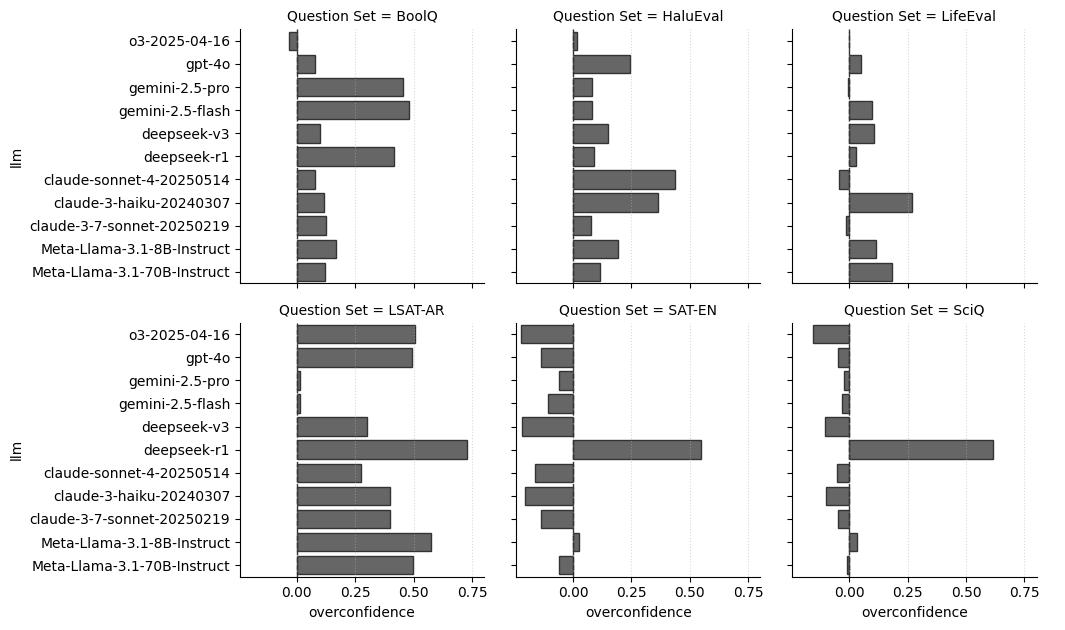

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# df has columns: "Question Set", "Model", "Overconfidence"
d = sum_df.copy()
model_order = sorted(d["Model"].unique())[::-1]      # same order in all panels

g = sns.catplot(
    data=d, kind="bar",
    x="Overconfidence", y="Model",
    col="Question Set", col_wrap=3,
    order=model_order, ci=None, color="0.4",
    height=3.2, aspect=1.1, edgecolor="0.2"
)

xmin = min(-0.05, d["Overconfidence"].min()*1.1)
xmax = max( 0.05, d["Overconfidence"].max()*1.1)
g.set(xlim=(xmin, xmax), xlabel="overconfidence", ylabel="llm")

for ax in g.axes.flat:
    ax.axvline(0, linestyle="--", linewidth=1, color="0.2")
    ax.grid(True, axis="x", linestyle=":", alpha=0.5)

plt.tight_layout()
plt.show()
